#**HURRICANE CHAOS GAME**

PART II
```
Miriam Nohemi López Cruz
Vrije Universiteit Brussel, Belgium
Email: miriam.nohemi.lopez.cruz@vub.be
```



In [ ]:
# Only needed in Google Collab
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/MyDrive/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import the required packages
from PIL import Image
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Import the ML models libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV

# Import the functions to compute different evaluation metrics for the models
from sklearn.metrics import accuracy_score, f1_score, mean_absolute_error, mean_squared_error, classification_report, confusion_matrix


# **Datasets**

In [ ]:
# Load the dataset with clutter-metrics evaluated images.
df = pd.read_csv(path+'df.csv')
#Changing name of columns to match them with the terms used in the thesis report
df = df.rename(columns={"CONTOUR_DENSITY": "EDGE_DENSITY", "FIG_GROUND": "FIG_GROUND_CONTRAST"})

In [ ]:
print(df['evaluation'].value_counts())

evaluation
 1    4693
 0    2509
-1     372
Name: count, dtype: int64


In [ ]:
# Combining 0 and -1 evaluation categories to reduce class unbalace.
df['evaluation'].replace(to_replace={-1:0}, inplace=True)
print(df['evaluation'].value_counts())

evaluation
1    4693
0    2881
Name: count, dtype: int64


<ipython-input-64-65c711b5d46c>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['evaluation'].replace(to_replace={-1:0}, inplace=True)


In [ ]:
# Replace all the categorical non numerical values to numerical values and change their data type.
theme_dict = {"CityOldKids":"0", "CityYoungKids":"1", "FantasyOldKids":"2", "FantasyYoungKids":"3", "Farm":"4", "Pirates":"5"}
df["theme"].replace(theme_dict, inplace=True)
df[["perspective", "rotate_images", "adaptive", "background_difficulty"]] = df[["perspective", "rotate_images", "adaptive", "background_difficulty"]].apply(lambda col: col.replace({"f": "0", "t": "1"}))
df[["theme", "perspective", "rotate_images", "adaptive", "background_difficulty"]] = df[["theme","perspective", "rotate_images", "adaptive", "background_difficulty"]].apply(lambda col: col.astype(int))

<ipython-input-65-a89e601ef62c>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["theme"].replace(theme_dict, inplace=True)


In [ ]:
#Columns to remove

# Remove all layer-specific data based on performance
cols_to_remove_to_all = ['id', 'start_date', 'end_date', 'wrong_selection', 'hint_used', 'hints_count', 'evaluation_details', 'duration', 'background', 'ended_early', 'earned_stars']

# Remove all features except for clutter metrics, general_difficulty and adaptive
cols_to_remove_to_dataset_2 = ['id','start_date', 'end_date', 'duration', 'objects', 'distractors', 'rotate_images', 'max_overlap', 'min_distance_from_border',
                     'min_size', 'max_size', 'hint_used', 'hints_count', 'wrong_selection', 'evaluation_details','background', 'earned_stars', 'max_stars_possible',
                     'theme', 'perspective', 'ended_early', 'background_difficulty']


In [ ]:
# Drop columns
dataset_1 = df.drop(columns=cols_to_remove_to_all)
dataset_2 = df.drop(columns=cols_to_remove_to_dataset_2)
dataset_3 = df.drop(columns=cols_to_remove_to_dataset_2 + ['adaptive'])

In [ ]:
# Aditionally, we will divide dataset_3 (the one containing the clutter metrics + the general difficulty) into to groups:  'adaptive' and 'non-adaptive',
# to check if there are significant differences in the results
dataset_4 = dataset_2[dataset_2['adaptive'] == 1]
dataset_4 = dataset_4.drop(columns=['adaptive'])
dataset_5 = dataset_2[dataset_2['adaptive'] == 0]
dataset_5 = dataset_5.drop(columns=['adaptive'])

In [ ]:
print(dataset_1.shape)
print(dataset_2.shape)
print(dataset_3.shape)
print(dataset_4.shape)
print(dataset_5.shape)

(7574, 20)
(7574, 9)
(7574, 8)
(3228, 8)
(4346, 8)


**DATASETS WITH UAE**

In [ ]:
# Load the dataset with clutter-metrics evaluated images.
#df6_simple = pd.read_csv(path+'df_simplenet.csv')
df6 = pd.read_csv(path+'df_trainet.csv')

#Changing name of columns to match them with the terms used in the thesis report
#df6_simple = df6_simple.rename(columns={"CONTOUR_DENSITY": "EDGE DENSITY", "FIG_GROUND": "FIG_GROUND_CONTRAST"})
df6 = df6.rename(columns={"CONTOUR_DENSITY": "EDGE DENSITY", "FIG_GROUND": "FIG_GROUND_CONTRAST"})

In [ ]:
#Merging with the original dataset and removing the same columns as in Dataset_3
#dataset6_simple = df6_simple.merge(df, on='id')
dataset_6 = df6.merge(df, on='id')

In [ ]:
#print(dataset6_simple['id'].nunique())
print(dataset_6['id'].nunique())

7270


In [ ]:
#dataset6_simple = dataset6_simple.drop_duplicates()
dataset_6 = dataset_6.drop_duplicates()

In [ ]:
#dataset6_simple = dataset6_simple.drop(columns=cols_to_remove_to_dataset_2 + ['adaptive'] + ['filename'] + ['energy_map_maxpool3'])
dataset_6 = dataset_6.drop(columns=cols_to_remove_to_dataset_2 + ['adaptive'] + ['filename'] + ['energy_map_maxpool3'])

In [ ]:
#dataset6_simple.head()

In [ ]:
#print(dataset6_simple.shape)
print(dataset_6.shape)

(7270, 10)


In [ ]:
#Count the number of negative evaluations on each dataset
dataset_list=[dataset_1, dataset_2, dataset_3, dataset_4, dataset_5, dataset_6]

for i, dataset in enumerate(dataset_list):
  negative = dataset[dataset['evaluation'] == 0]['evaluation'].count()
  positive = dataset[dataset['evaluation'] == 1]['evaluation'].count()
  total = dataset.shape[0]
  ratio = negative/total
  print (f"ratio of negative evaluations in Dataset_{i}:{ratio}")

ratio of negative evaluations in Dataset_0:0.3803802482175865
ratio of negative evaluations in Dataset_1:0.3803802482175865
ratio of negative evaluations in Dataset_2:0.3803802482175865
ratio of negative evaluations in Dataset_3:0.4838909541511772
ratio of negative evaluations in Dataset_4:0.3034974689369535
ratio of negative evaluations in Dataset_5:0.3815680880330124


In [ ]:
df_dict =  {'Dataset_1': {'df':dataset_1},
            'Dataset_2': {'df':dataset_2},
            'Dataset_3': {'df':dataset_3},
            'Dataset_4': {'df':dataset_4},
            'Dataset_5': {'df':dataset_5},
            'Dataset_6': {'df':dataset_6}
            }

In [ ]:
print(df_dict.keys())

dict_keys(['Dataset_1', 'Dataset_2', 'Dataset_3', 'Dataset_4', 'Dataset_5', 'Dataset_6'])


# **Random Forest: Pipeline**

In [ ]:
# Function to split the data into X and y
def split_X_y(df, target_col):
    # Split dataframe into X and y
    X = df.drop(target_col, axis=1)
    y = df[target_col]
    return X, y

In [ ]:
# Function to split the data into train and test sets
def split_data(X, y, test_size=0.2):
  """
  Splits the data into training and test sets with stratified sampling.
  """
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)

  return X_train, X_test, y_train, y_test

In [ ]:
# Function to perform Randomnized Search
def random_search_cv(X_train, X_test, y_train, y_test, param_dist, scoring):
  """
  Performs RandomizedSearchCV for hyperparameter tuning.
  """
  rf_clf = RandomForestClassifier(random_state=42)
  random_search = RandomizedSearchCV(
      estimator=rf_clf, param_distributions = param_dist, scoring=scoring, n_iter=20, cv=5, verbose=1)
  random_search.fit(X_train, y_train)
  return random_search.best_params_

In [ ]:
# Function to perform Grid Search CV
def grid_search_cv(X_train, y_train, param_grid, scoring):
  """
  Performs GridSearchCV for hyperparameter tuning.
  """
  rf_clf = RandomForestClassifier(random_state=42)
  grid_search = GridSearchCV(
      estimator=rf_clf, param_grid=param_grid, scoring=scoring, cv=5, verbose=1)
  grid_search.fit(X_train, y_train)
  return grid_search.best_params_

In [ ]:
# Function to train and test the model
def train_and_evaluate(X_train, X_test, y_train, params):
    """
    Trains the RandomForestClassifier with the given parameters and evaluates it.
    """
    model = RandomForestClassifier(**params, random_state=42)
    estimator_rf = model.fit(X_train, y_train)
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)
    #f1_train = f1_score(y_train, train_predictions)
    #f1_test = f1_score(y_test, test_predictions)
    return estimator_rf, train_predictions,test_predictions

In [ ]:
# Set up the parameter distribution for random search
param_dist = {
  'max_depth': range(1,40,5),
  'min_samples_split': range(2,80,1),
  'min_samples_leaf': range(1,80,10)
}

In [ ]:
# Main function
def rf_model(df, target_column, param_dist, scoring):
    """
    Full pipeline: data splitting, hyperparameter tuning, training, and evaluation.
    """
    X, y = split_X_y(df, target_column)
    X_train, X_test, y_train, y_test = split_data(X, y)

    print("Performing RandomizedSearchCV...")
    best_params_random = random_search_cv(X_train, X_test, y_train, y_test, param_dist=param_dist, scoring=scoring)
    print("Best parameters (RandomizedSearchCV):", best_params_random)

    # Grid search with the best parameters from random search
    param_grid = {
        'min_samples_split': [best_params_random['min_samples_split'],best_params_random['min_samples_split']+20, 5],
        'min_samples_leaf': [best_params_random['min_samples_leaf'], best_params_random['min_samples_leaf']+20, 5],
        'max_depth': range(1,best_params_random['max_depth'],5)
        }
    print("Performing GridSearchCV...")
    best_params_grid = grid_search_cv(X_train, y_train, param_grid=param_grid, scoring=scoring)
    print("Best parameters (GridSearchCV):", best_params_grid)

    # Final model training and evaluation
    print("Training and evaluating model...")
    estimator_rf, train_predictions, test_predictions = train_and_evaluate(X_train, X_test, y_train, best_params_grid)

    # Evaluation for the TRAIN set
    print("TRAIN SET EVALUATION:")
    print("Classification Report:\n", classification_report(y_train, train_predictions))
    print("Confusion Matrix:\n", confusion_matrix(y_train, train_predictions))

    # Evaluation for the TEST set
    print("\nTEST SET EVALUATION:")
    print("Classification Report:\n", classification_report(y_test, test_predictions))
    print("Confusion Matrix:\n", confusion_matrix(y_test, test_predictions))

    return X, X_train, X_test, y_train, y_test, best_params_grid, estimator_rf, train_predictions, test_predictions


In [ ]:
for key, value in df_dict.items():
  X, X_train, X_test, y_train, y_test, best_params_grid, estimator_rf, train_predictions, test_predictions = rf_model(value['df'], 'evaluation', param_dist, 'balanced_accuracy')
  value['X'] = X
  value['X_train'] = X_train
  value['X_test'] = X_test
  value['y_train'] = y_train
  value['y_test'] = y_test
  value['best_params'] = best_params_grid
  value['estimator'] = estimator_rf
  value['train_predictions'] = train_predictions
  value['test_predictions'] = test_predictions


Performing RandomizedSearchCV...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters (RandomizedSearchCV): {'min_samples_split': 24, 'min_samples_leaf': 11, 'max_depth': 36}
Performing GridSearchCV...
Fitting 5 folds for each of 63 candidates, totalling 315 fits
Best parameters (GridSearchCV): {'max_depth': 16, 'min_samples_leaf': 5, 'min_samples_split': 5}
Training and evaluating model...
TRAIN SET EVALUATION:
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.76      0.84      2305
           1       0.87      0.96      0.91      3754

    accuracy                           0.89      6059
   macro avg       0.90      0.86      0.87      6059
weighted avg       0.89      0.89      0.88      6059

Confusion Matrix:
 [[1748  557]
 [ 133 3621]]

TEST SET EVALUATION:
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.51      0.58       576
       

In [ ]:
#To check datasets individually
#rf_model(dataset_1, 'evaluation', param_dist, 'balanced_accuracy')

# **VISUALIZATION**

# **Confusion Matrix**

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

[[0.75835141 0.24164859]
 [0.03542888 0.96457112]]
[[0.50520833 0.49479167]
 [0.14589989 0.85410011]]


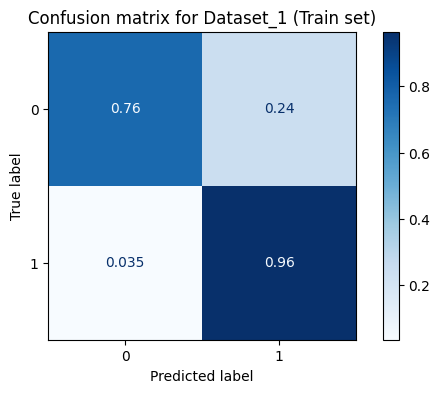

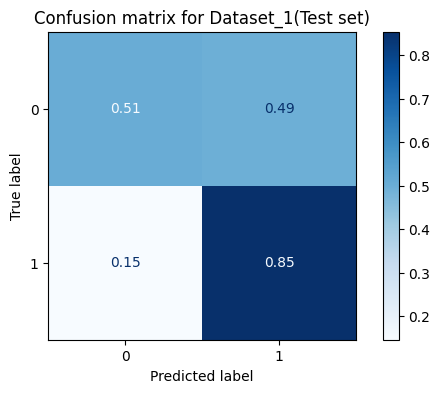

[[0.95835141 0.04164859]
 [0.00346297 0.99653703]]
[[0.46354167 0.53645833]
 [0.13631523 0.86368477]]


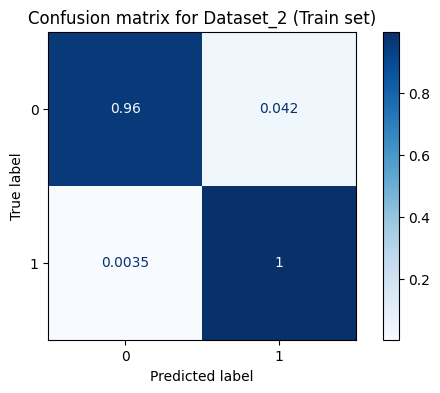

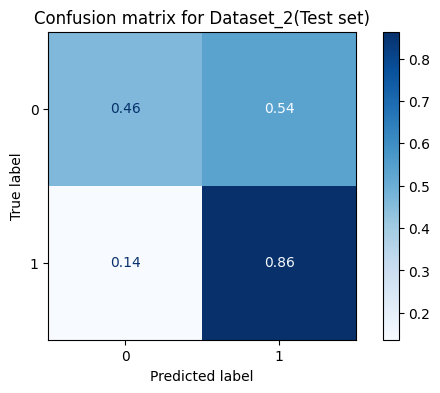

[[0.95921909 0.04078091]
 [0.00319659 0.99680341]]
[[0.40972222 0.59027778]
 [0.1256656  0.8743344 ]]


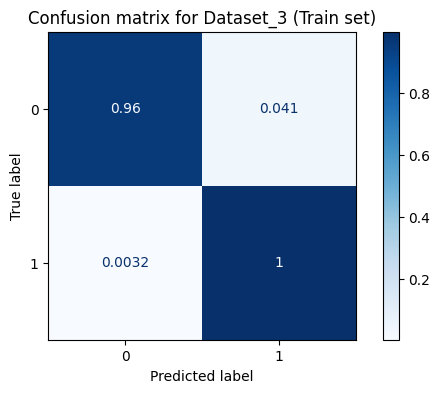

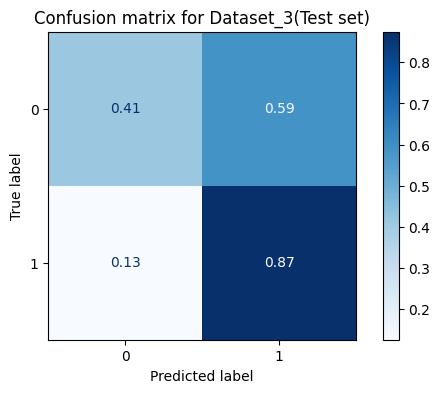

[[0.88230584 0.11769416]
 [0.08852213 0.91147787]]
[[0.60383387 0.39616613]
 [0.29129129 0.70870871]]


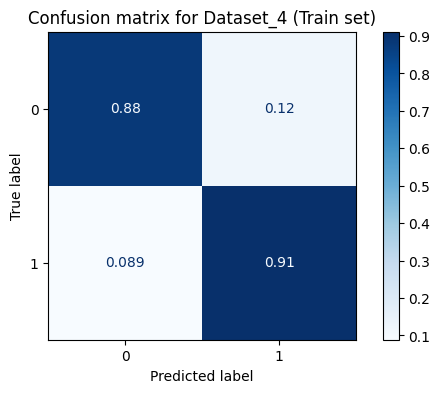

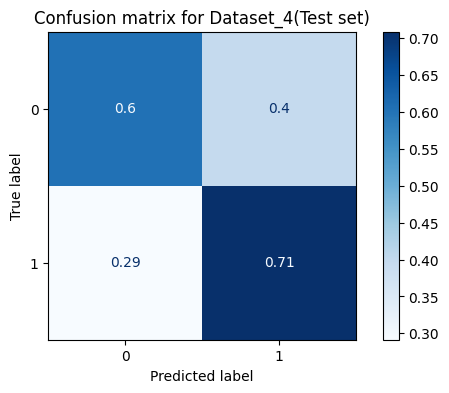

[[0.1478673  0.8521327 ]
 [0.01280463 0.98719537]]
[[0.09090909 0.90909091]
 [0.02640264 0.97359736]]


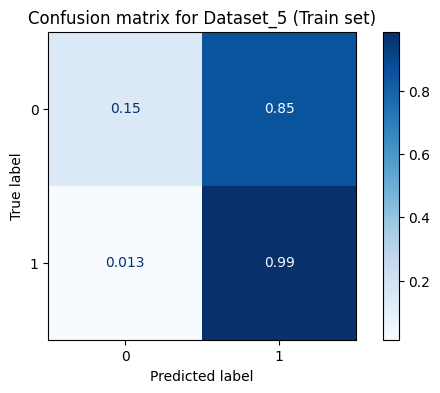

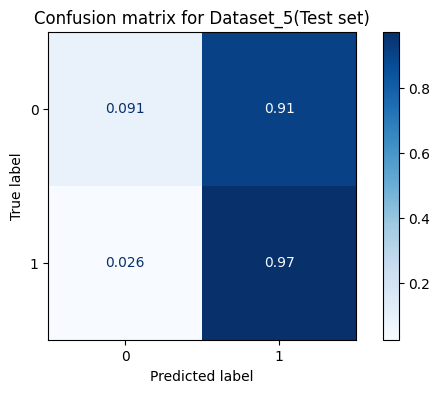

[[9.99549347e-01 4.50653447e-04]
 [0.00000000e+00 1.00000000e+00]]
[[0.41441441 0.58558559]
 [0.18131257 0.81868743]]


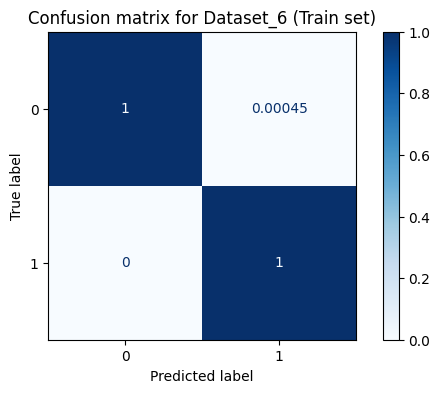

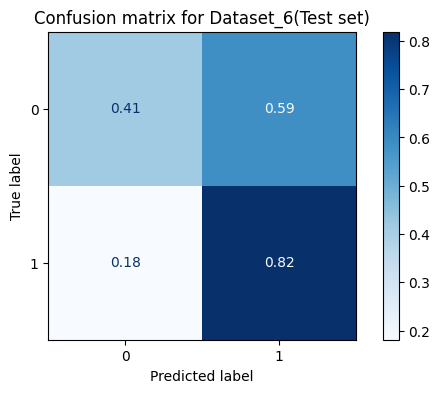

In [ ]:
# To visualize the Confusion Matrix (Normalized)

for dataset_name, data_dict in df_dict.items():
  # Create separate figures for train and test confusion matrices
  fig_train, ax_train = plt.subplots(figsize=(7, 4))  # Adjust figsize for single plot
  fig_test, ax_test = plt.subplots(figsize=(7, 4))

  # Access the data arrays using the keys within data_dict
  y_train = data_dict['y_train']
  train_predictions = data_dict['train_predictions']
  y_test = data_dict['y_test']
  test_predictions = data_dict['test_predictions']

  # Plot normalized confusion matrix for train set
  disp_train = ConfusionMatrixDisplay.from_predictions(
    y_train,
    train_predictions,
    cmap=plt.cm.Blues,
    normalize="true",
    ax=ax_train  # Specify the axis for the train plot
    )
  disp_train.ax_.set_title(f"Confusion matrix for {dataset_name} (Train set)")
  print(disp_train.confusion_matrix)

  # Plot normalized confusion matrix for test set
  disp_test = ConfusionMatrixDisplay.from_predictions(
    y_test,
    test_predictions,
    cmap=plt.cm.Blues,
    normalize="true",
    ax=ax_test  # Specify the axis for the test plot
    )
  disp_test.ax_.set_title(f"Confusion matrix for {dataset_name}(Test set)")
  print(disp_test.confusion_matrix)
  plt.show()

# **Importance of features**

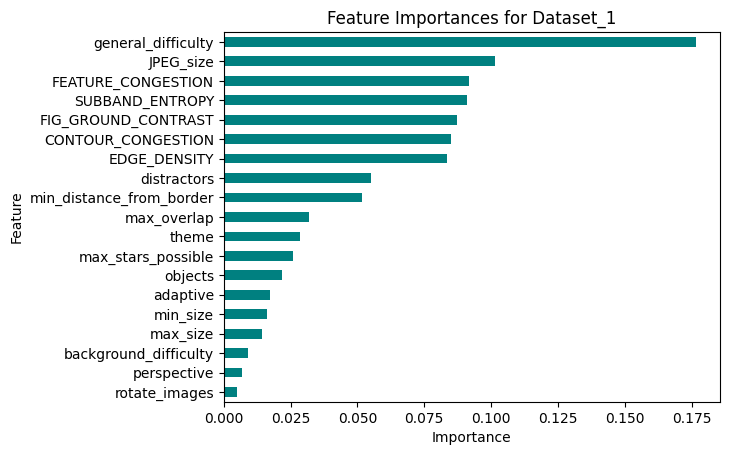

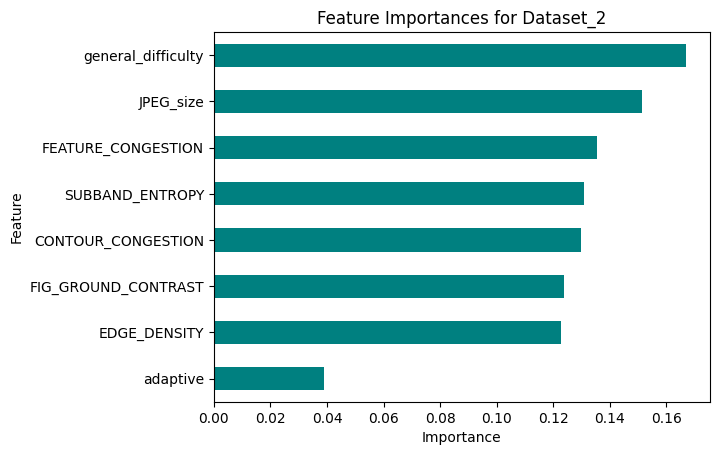

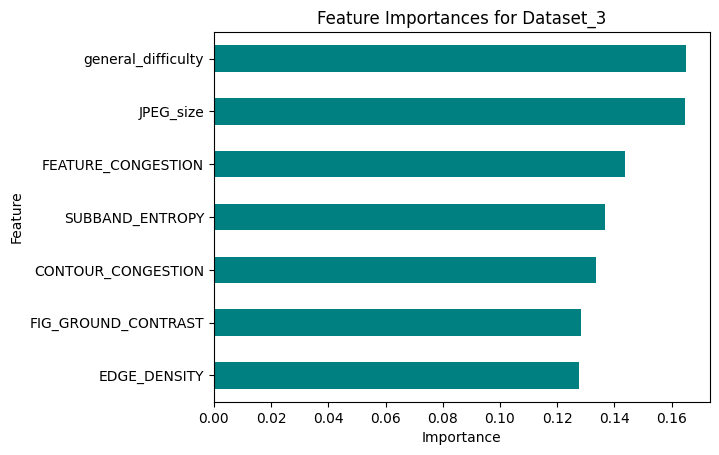

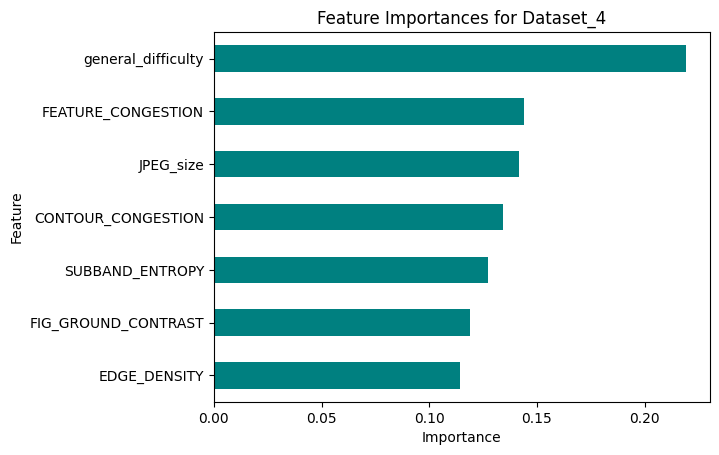

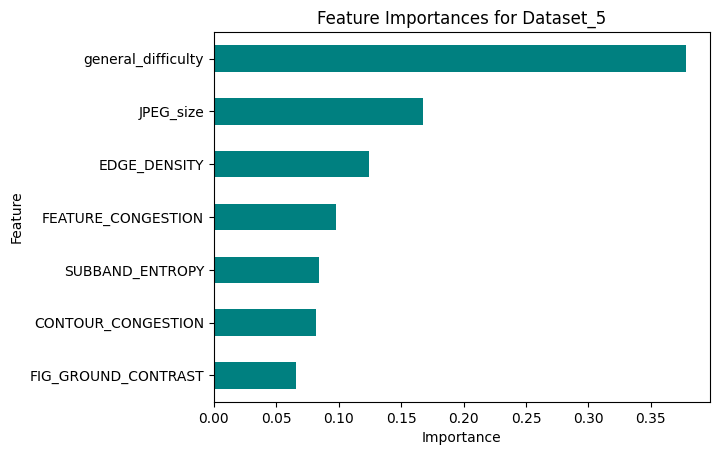

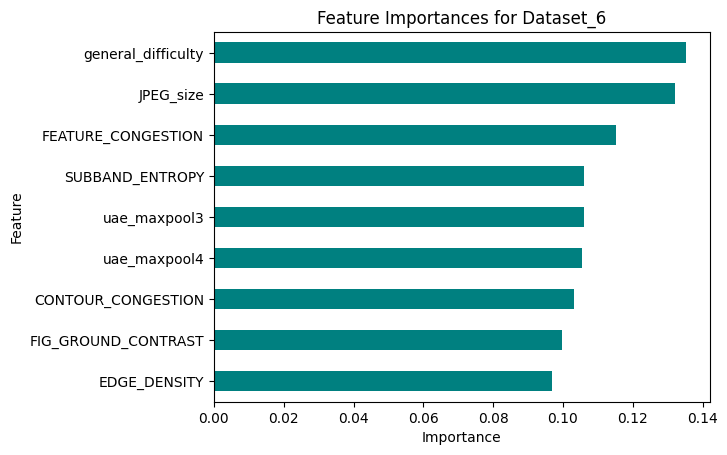

In [ ]:
# To visualize the importance of features
for dataset_name, data_dict in df_dict.items():
  # Access the data arrays using the keys within data_dict
  X = data_dict['X']
  estimator = data_dict['estimator']
  # Create a pd.Series of features importances
  importances_rf = pd.Series(estimator.feature_importances_, index=X.columns)
  #Sort importances_rf
  sorted_importances_rf= importances_rf.sort_values()
  #Make a horizontal bar plot
  sorted_importances_rf.plot(kind='barh', color='teal')
  plt.title(f"Feature Importances for {dataset_name}")
  plt.xlabel("Importance")
  plt.ylabel("Feature")
  plt.show()

In [ ]:
#rf_model(dataset6_simple, 'evaluation', param_dist, 'balanced_accuracy')

In [ ]:
rf_model(dataset_6, 'evaluation', param_dist, 'balanced_accuracy')

Performing RandomizedSearchCV...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters (RandomizedSearchCV): {'min_samples_split': 4, 'min_samples_leaf': 11, 'max_depth': 36}
Performing GridSearchCV...
Fitting 5 folds for each of 63 candidates, totalling 315 fits
Best parameters (GridSearchCV): {'max_depth': 16, 'min_samples_leaf': 5, 'min_samples_split': 4}
Training and evaluating model...
TRAIN SET EVALUATION:
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.83      0.90      2219
           1       0.90      0.99      0.94      3597

    accuracy                           0.93      5816
   macro avg       0.94      0.91      0.92      5816
weighted avg       0.93      0.93      0.93      5816

Confusion Matrix:
 [[1841  378]
 [  46 3551]]

TEST SET EVALUATION:
Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.39      0.47       555
        

(      uae_maxpool3  uae_maxpool4  JPEG_size  EDGE_DENSITY  SUBBAND_ENTROPY  \
 0         0.065312      0.021449     136431        0.0270           2.7053   
 1         0.060279      0.022352     119293        0.0200           2.9284   
 2         0.038582      0.010538     130581        0.0251           2.9150   
 3         0.077244      0.018657     126854        0.0159           2.2743   
 4         0.087493      0.028886     129456        0.0194           2.4222   
 ...            ...           ...        ...           ...              ...   
 7569      0.063772      0.016413     163003        0.0239           3.0941   
 7570      0.057746      0.019969     160067        0.0227           3.0847   
 7571      0.087416      0.016313     145125        0.0204           3.0177   
 7572      0.077727      0.019770     145085        0.0203           2.8035   
 7573      0.093546      0.018926     134787        0.0212           2.9209   
 
       FEATURE_CONGESTION  FIG_GROUND_CONTRAST  CO

# **Implementing a Re-sampling technique to achieve data-level balancing**

SMOTE (Synthetic Minority Oversampling Technique)



In [ ]:
from imblearn.over_sampling import SMOTE

dataset_1 = df_dict['Dataset_1']
X_train = dataset_1['X_train']
X_test = dataset_1['X_test']
y_train = dataset_1['y_train']
y_test = dataset_1['y_test']


# Resample the data
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

#Best from grid Search
rfc_ops_smote = {'max_depth': 16,
                  'min_samples_leaf': 5,
                  'min_samples_split': 5,
                 'random_state':42}

# Train the model on resampled data
rf_smote = RandomForestClassifier(**rfc_ops_smote)
estimator_smote = rf_smote.fit(X_resampled, y_resampled)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


In [ ]:
# Test the model on the train and test set
y_train_resampled_pred = rf_smote.predict(X_resampled)
y_test_resampled_pred = rf_smote.predict(X_test)

# Print classification report
print(classification_report(y_resampled, y_train_resampled_pred))
print(classification_report(y_test, y_test_resampled_pred))

              precision    recall  f1-score   support

           0       0.92      0.88      0.90      3754
           1       0.89      0.92      0.90      3754

    accuracy                           0.90      7508
   macro avg       0.90      0.90      0.90      7508
weighted avg       0.90      0.90      0.90      7508

              precision    recall  f1-score   support

           0       0.62      0.60      0.61       576
           1       0.76      0.78      0.77       939

    accuracy                           0.71      1515
   macro avg       0.69      0.69      0.69      1515
weighted avg       0.71      0.71      0.71      1515



[[0.88492275 0.11507725]
 [0.07858284 0.92141716]]


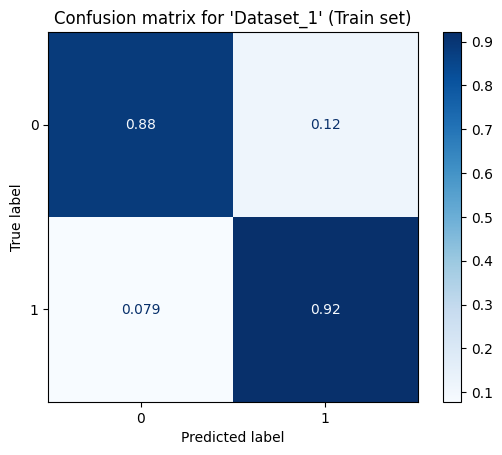

In [ ]:
# Plot normalized confusion matrix for every dataset
disp = ConfusionMatrixDisplay.from_estimator(
  estimator_smote,
  X_resampled,
  y_resampled,
  display_labels=np.unique(y_resampled),
  cmap=plt.cm.Blues,
  normalize="true",
  )
disp.ax_.set_title("Confusion matrix for 'Dataset_1' (Train set)")

#print(title)
print(disp.confusion_matrix)

plt.show()

[[0.59722222 0.40277778]
 [0.22044728 0.77955272]]


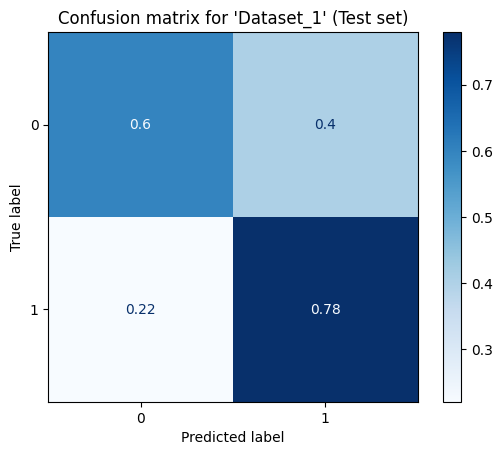

In [ ]:
# Plot normalized confusion matrix for every dataset
disp = ConfusionMatrixDisplay.from_estimator(
  estimator_smote,
  X_test,
  y_test,
  display_labels=np.unique(y_test),
  cmap=plt.cm.Blues,
  normalize="true",
  )
disp.ax_.set_title(f"Confusion matrix for 'Dataset_1' (Test set)")

#print(title)
print(disp.confusion_matrix)

plt.show()

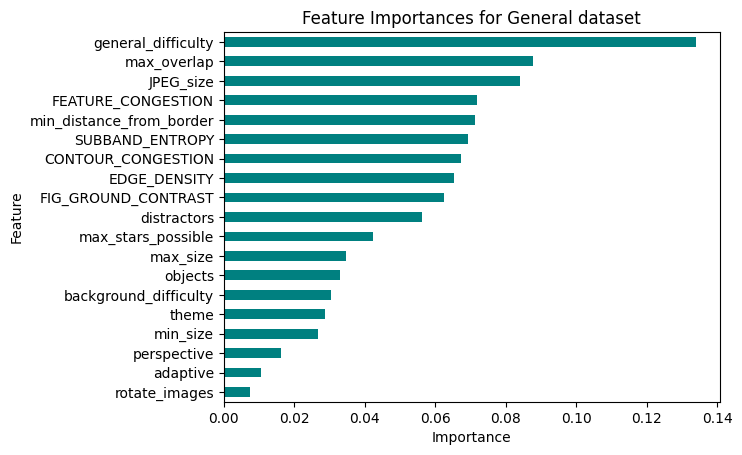

In [ ]:
# Create a pd.Series of features importances
importances_rf = pd.Series(estimator_smote.feature_importances_, index=X_resampled.columns)
#Sort importances_rf
sorted_importances_rf= importances_rf.sort_values()
#Make a horizontal bar plot
sorted_importances_rf.plot(kind='barh', color='teal')
plt.title(f"Feature Importances for General dataset")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

################## DATASET 6 SIMPLE


In [ ]:
from imblearn.over_sampling import SMOTE

dataset_6 = df_dict['Dataset_6']
X_train = dataset_6['X_train']
X_test = dataset_6['X_test']
y_train = dataset_6['y_train']
y_test = dataset_6['y_test']


# Resample the data
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

#Best from grid Search
rfc_ops_smote = {'max_depth': 16,
                 'min_samples_leaf': 1,
                 'min_samples_split': 19,
                 'random_state':42}

# Train the model on resampled data
rf_smote = RandomForestClassifier(**rfc_ops_smote)
estimator_smote = rf_smote.fit(X_resampled, y_resampled)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


In [ ]:
# Test the model on the train and test set
y_train_resampled_pred = rf_smote.predict(X_resampled)
y_test_resampled_pred = rf_smote.predict(X_test)

# Print classification report
print(classification_report(y_resampled, y_train_resampled_pred))
print(classification_report(y_test, y_test_resampled_pred))

              precision    recall  f1-score   support

           0       0.87      0.94      0.90      3597
           1       0.93      0.86      0.90      3597

    accuracy                           0.90      7194
   macro avg       0.90      0.90      0.90      7194
weighted avg       0.90      0.90      0.90      7194

              precision    recall  f1-score   support

           0       0.53      0.62      0.57       555
           1       0.74      0.66      0.69       899

    accuracy                           0.64      1454
   macro avg       0.63      0.64      0.63      1454
weighted avg       0.66      0.64      0.65      1454



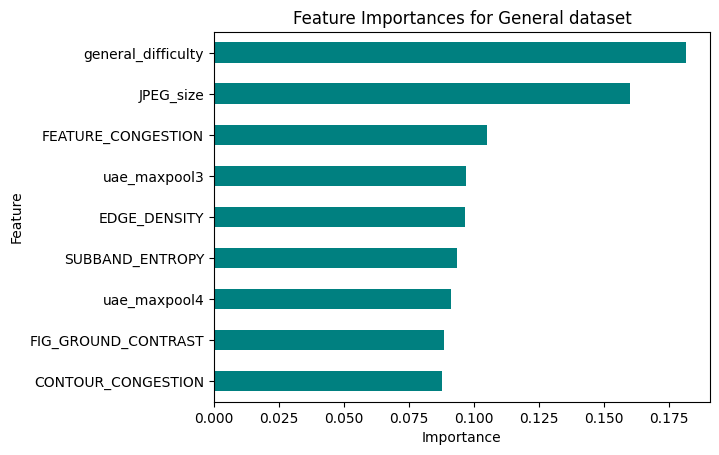

In [ ]:
# Create a pd.Series of features importances
importances_rf = pd.Series(estimator_smote.feature_importances_, index=X_resampled.columns)
#Sort importances_rf
sorted_importances_rf= importances_rf.sort_values()
#Make a horizontal bar plot
sorted_importances_rf.plot(kind='barh', color='teal')
plt.title(f"Feature Importances for General dataset")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

##################


FUNCION SMOTE

In [ ]:
def smote_model(datasetkey):
  dataset = df_dict[datasetkey]
  # Resample the data
  smote = SMOTE(random_state=42)
  X_resampled, y_resampled = smote.fit_resample(dataset['X_train'], dataset['y_train'])

  #Train the model on resampled data
  rf_smote = RandomForestClassifier(**dataset['best_params'])
  estimator_smote = rf_smote.fit(X_resampled, y_resampled)

  # Test the model on the train and test set
  y_train_resampled_pred = rf_smote.predict(X_resampled)
  y_test_resampled_pred = rf_smote.predict(dataset['X_test'])

  # Print classification report
  print(classification_report(y_resampled, y_train_resampled_pred))
  print(classification_report(dataset['y_test'], y_test_resampled_pred))

  # Plot normalized confusion matrix for train set
  disp = ConfusionMatrixDisplay.from_estimator(
      estimator_smote,
      X_resampled,
      y_resampled,
      display_labels=np.unique(y_resampled),
      cmap=plt.cm.Blues,
      normalize="true"
      )
  disp.ax_.set_title(f"Confusion matrix for {datasetkey} (Train set)")
  print(disp.confusion_matrix)
  plt.show()

  # Plot normalized confusion matrix for test set
  disp = ConfusionMatrixDisplay.from_estimator(
      estimator_smote,
      dataset['X_test'],
      dataset['y_test'],
      display_labels=np.unique(dataset['y_test']),
      cmap=plt.cm.Blues,
      normalize="true"
      )
  disp.ax_.set_title(f"Confusion matrix for {datasetkey} (Test set)")
  print(disp.confusion_matrix)
  plt.show()

  # Create a pd.Series of features importances
  importances_rf = pd.Series(estimator_smote.feature_importances_, index=X_resampled.columns)
  #Sort importances_rf
  sorted_importances_rf= importances_rf.sort_values()
  #Make a horizontal bar plot
  sorted_importances_rf.plot(kind='barh', color='teal')
  plt.title(f"Feature Importance")
  plt.xlabel("Importance")
  plt.ylabel("Feature")
  plt.show()



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.92      0.88      0.90      3754
           1       0.89      0.92      0.91      3754

    accuracy                           0.90      7508
   macro avg       0.90      0.90      0.90      7508
weighted avg       0.90      0.90      0.90      7508

              precision    recall  f1-score   support

           0       0.63      0.61      0.62       576
           1       0.76      0.78      0.77       939

    accuracy                           0.71      1515
   macro avg       0.70      0.69      0.69      1515
weighted avg       0.71      0.71      0.71      1515

[[0.88438998 0.11561002]
 [0.07725093 0.92274907]]


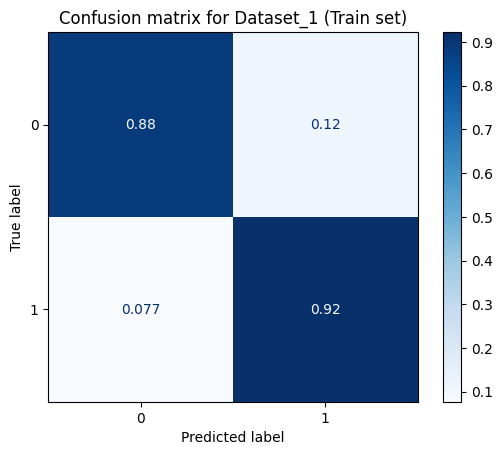

[[0.61111111 0.38888889]
 [0.22364217 0.77635783]]


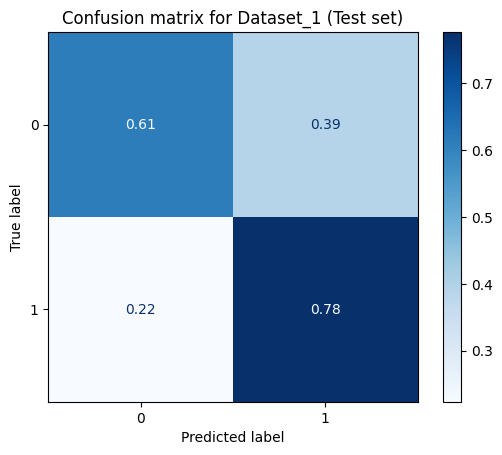

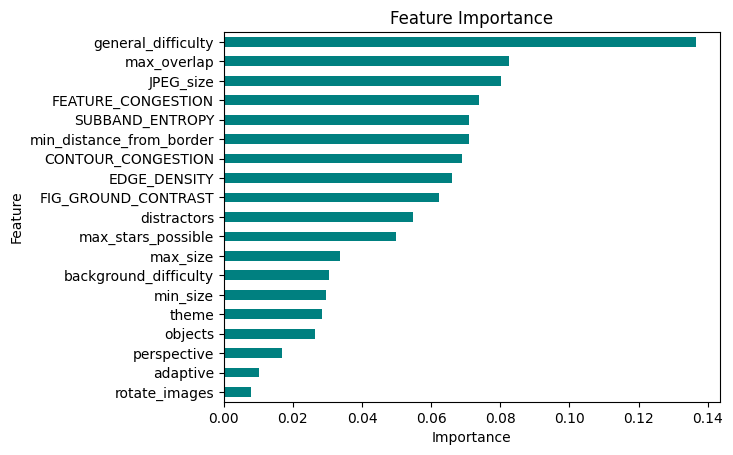

In [ ]:
smote_model('Dataset_1')

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.92      0.99      0.95      3754
           1       0.99      0.91      0.95      3754

    accuracy                           0.95      7508
   macro avg       0.96      0.95      0.95      7508
weighted avg       0.96      0.95      0.95      7508

              precision    recall  f1-score   support

           0       0.53      0.65      0.59       576
           1       0.75      0.64      0.69       939

    accuracy                           0.65      1515
   macro avg       0.64      0.65      0.64      1515
weighted avg       0.67      0.65      0.65      1515

[[0.99467235 0.00532765]
 [0.09136921 0.90863079]]


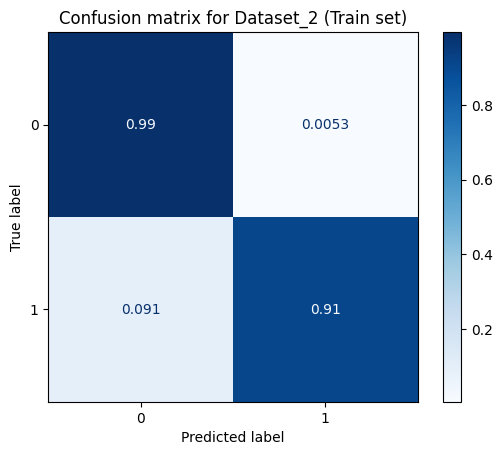

[[0.65451389 0.34548611]
 [0.35676251 0.64323749]]


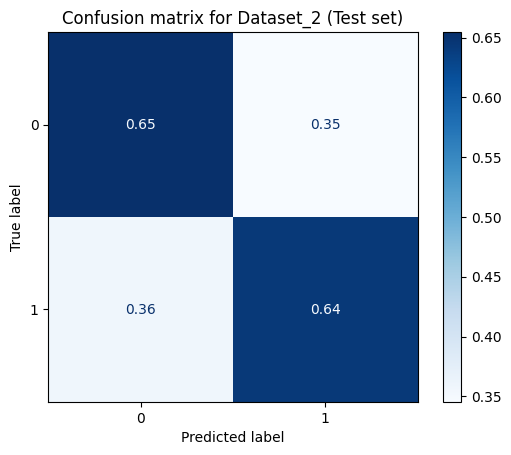

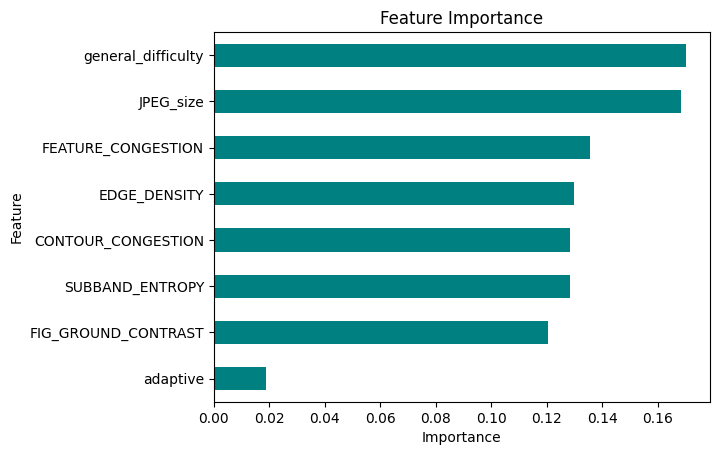

In [ ]:
smote_model('Dataset_2')

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.92      1.00      0.96      3754
           1       1.00      0.91      0.95      3754

    accuracy                           0.95      7508
   macro avg       0.96      0.95      0.95      7508
weighted avg       0.96      0.95      0.95      7508

              precision    recall  f1-score   support

           0       0.55      0.65      0.60       576
           1       0.76      0.67      0.71       939

    accuracy                           0.66      1515
   macro avg       0.65      0.66      0.65      1515
weighted avg       0.68      0.66      0.67      1515

[[0.99573788 0.00426212]
 [0.08897176 0.91102824]]


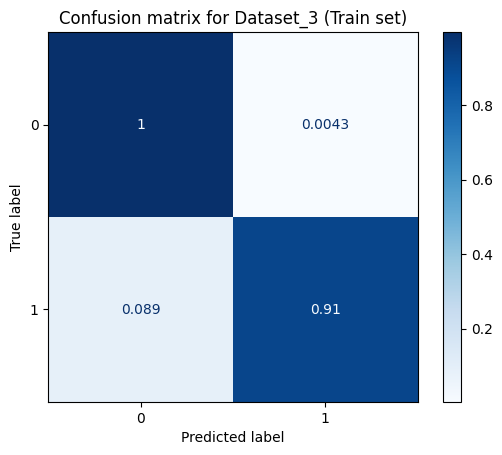

[[0.65277778 0.34722222]
 [0.33120341 0.66879659]]


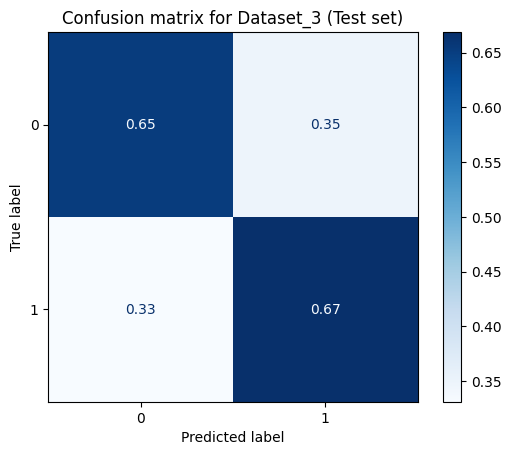

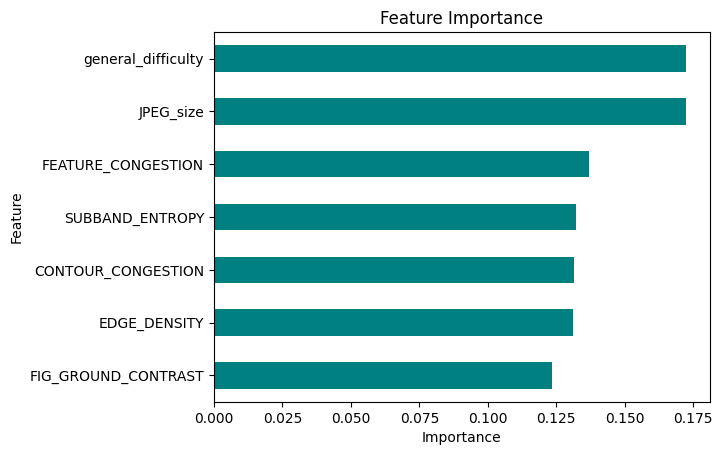

In [ ]:
smote_model('Dataset_3')

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.90      0.90      0.90      1333
           1       0.90      0.90      0.90      1333

    accuracy                           0.90      2666
   macro avg       0.90      0.90      0.90      2666
weighted avg       0.90      0.90      0.90      2666

              precision    recall  f1-score   support

           0       0.66      0.66      0.66       313
           1       0.68      0.68      0.68       333

    accuracy                           0.67       646
   macro avg       0.67      0.67      0.67       646
weighted avg       0.67      0.67      0.67       646

[[0.89797449 0.10202551]
 [0.09527382 0.90472618]]


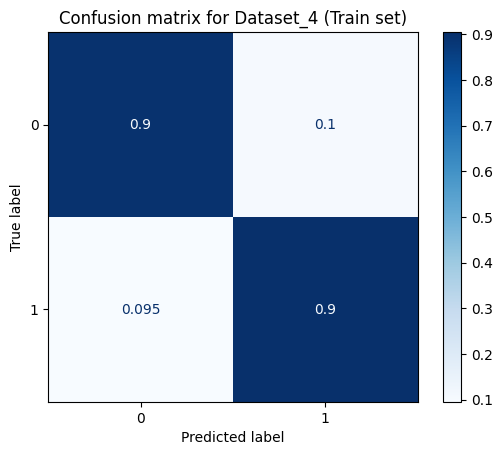

[[0.65814696 0.34185304]
 [0.31531532 0.68468468]]


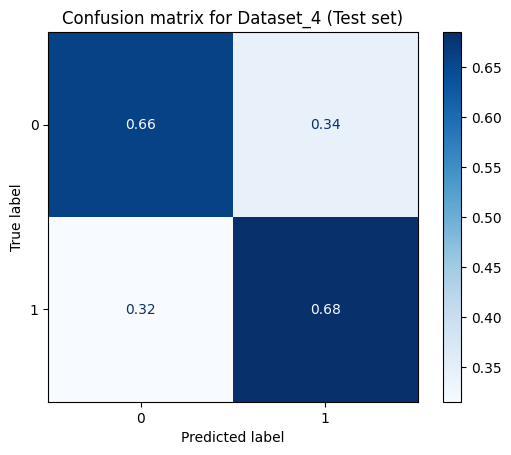

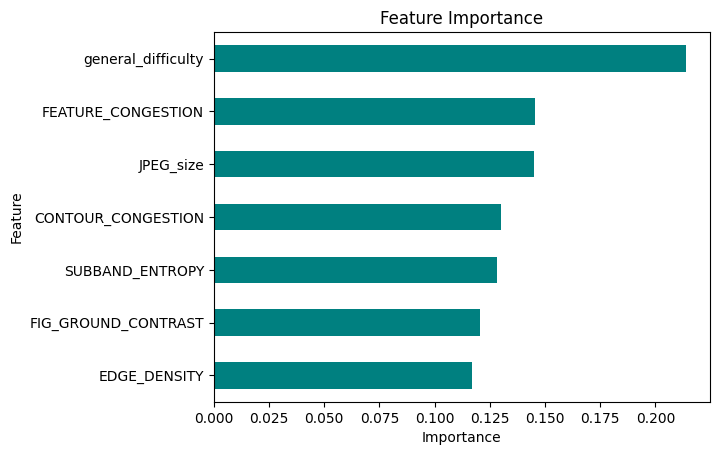

In [ ]:
smote_model('Dataset_4')

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.71      0.80      0.75      2421
           1       0.77      0.68      0.72      2421

    accuracy                           0.74      4842
   macro avg       0.74      0.74      0.73      4842
weighted avg       0.74      0.74      0.73      4842

              precision    recall  f1-score   support

           0       0.46      0.68      0.55       264
           1       0.82      0.65      0.73       606

    accuracy                           0.66       870
   macro avg       0.64      0.67      0.64       870
weighted avg       0.71      0.66      0.67       870

[[0.79553903 0.20446097]
 [0.32424618 0.67575382]]


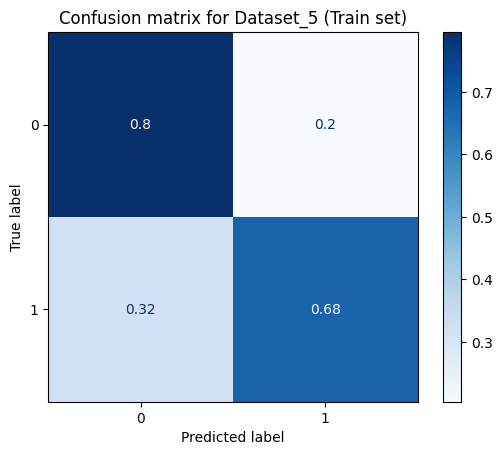

[[0.68181818 0.31818182]
 [0.34983498 0.65016502]]


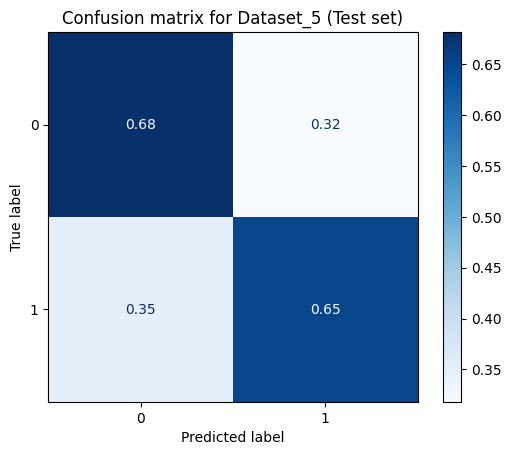

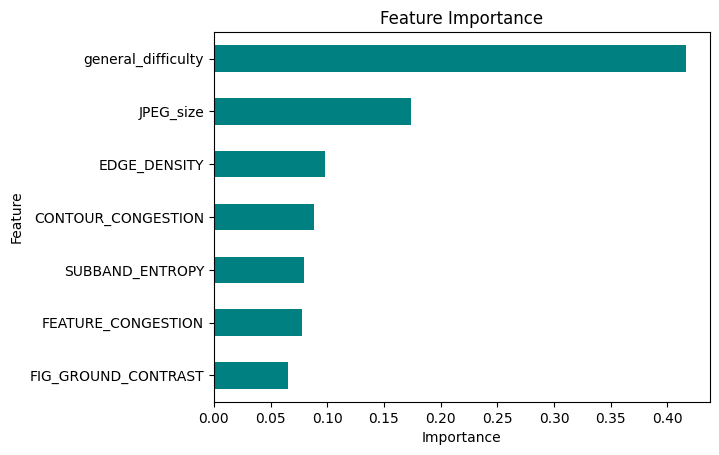

In [ ]:
smote_model('Dataset_5')

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3597
           1       1.00      0.99      0.99      3597

    accuracy                           0.99      7194
   macro avg       0.99      0.99      0.99      7194
weighted avg       0.99      0.99      0.99      7194

              precision    recall  f1-score   support

           0       0.54      0.59      0.56       555
           1       0.73      0.69      0.71       899

    accuracy                           0.65      1454
   macro avg       0.63      0.64      0.63      1454
weighted avg       0.66      0.65      0.65      1454

[[1.         0.        ]
 [0.01306644 0.98693356]]


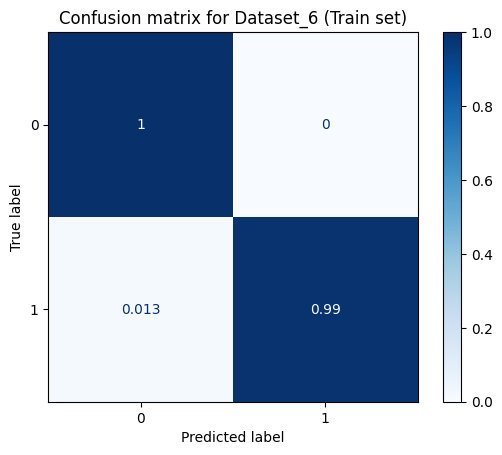

[[0.58738739 0.41261261]
 [0.31256952 0.68743048]]


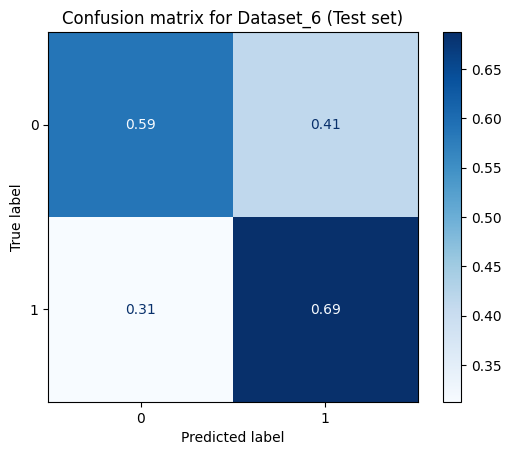

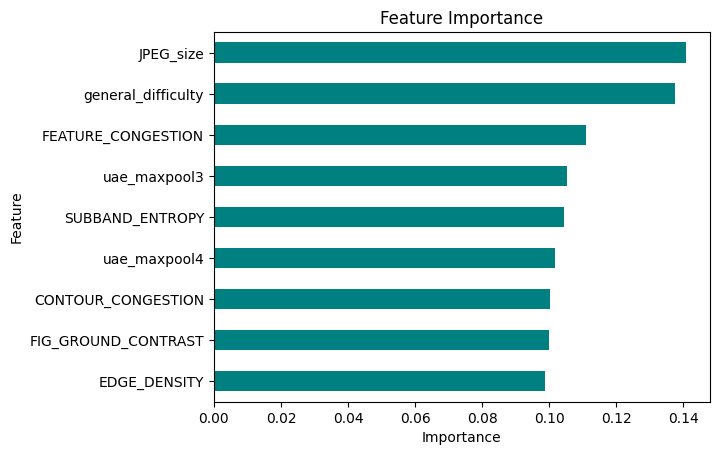

In [ ]:
smote_model('Dataset_6')